# Simple Unet Model to Segment a Single Malignancy from Mammograms

### Using TensorFlow Input Pipeline

| Class               | Grayscale Value | Color Name | RGB Value        |
|---------------------|-----------------|------------|------------------|
| `background`        | `0` - 0.              | black      | `RGB (0, 0, 0)`  |
| `malignant_mass`    | `76` - 1.            | red        | `RGB (255, 0, 0)`|
| `benign_mass`       | `149` - 2.           | green      | `RGB (0, 255, 0)`|
| `macrocalcifications` | `178` - 3.         | cyan       | `RGB (0, 255, 255)`|
| `microcalcifications` | `255` - 4.         | white      | `RGB (255, 255, 255)`|


In [1]:
# %pip install focal-loss
# %pip install segmentation_models

# only for error correction if using segmentation_models - of keras.utils
# %env SM_FRAMEWORK=tf.keras

In [2]:
# if something goes wrong with the variables - run this and clear everything
%reset -f

In [3]:
import tensorflow as tf

print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

strategy = tf.distribute.MirroredStrategy()

Number of GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random

import sys
sys.path.append('../../utils')
sys.path.append('../../models')

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

**Filtering Data**

In [5]:
df = pd.read_csv('../../data/raw/data_filtered.csv')
df = df[df['status'] == 'abnormal']
df.head()

,patient_id,image_id,view,status,m_mass,b_mass,mic_cluster,mac,z_index,breast_density,notes,Unnamed: 11
10,3,0003-RCC,RCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
11,3,0003-RMLO,RMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
16,5,0005-LCC,LCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
17,5,0005-LMLO,LMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
22,12,0012-LCC,LCC,abnormal,0.0,1.0,0.0,1.0,NaN,Scattered Fibroglandular Densities,NaN,NaN


In [6]:
len(df)

497

**Prepare Filepaths**

In [10]:
# most common ratio for cropped images ----- h = 1.8 * w
# w = 1000, h = 1800
# w = 1500, h = 2700
# w = 2000, h = 3600
# most common ratio for cropped images ----- h = 1.25 * w
# w = 1000, h = 1250
# w = 1500, h = 1875
# w = 2000, h = 2500

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

# if crop is not used
# IMAGE_HEIGHT = 4096//4
# IMAGE_WIDTH = 3328//4

# if crop is used
IMAGE_HEIGHT = 3200//4
IMAGE_WIDTH = 1728//4

image_size = (IMAGE_HEIGHT, IMAGE_WIDTH)

image_dir = '../../data/raw/abnormal/images/'
mask_dir = '../../data/raw/abnormal/masks_colored/'

image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])[:-2]
mask_files = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir)])[:-2]

image_files_unseen = image_files[-2:]
mask_files_unseen = mask_files[-2:]

In [12]:
print(len(mask_files), len(image_files))

268 268


In [ ]:
n_classes = 5

# class indices based on grayscale values
class_values = {'background': 0, 'malignant_mass': 1, 'benign_mass': 2, 'macrocalcifications': 3, 'microcalcifications': 4}

**Pre-processing**

In [13]:
from preprocessing import crop_breast, dilate, truncate, clahe

def preprocessing_pipeline(img, mask):
    image, mask, new_height, new_width = crop_breast(img.numpy().squeeze(), mask.numpy().squeeze())
    # image = truncate(image, lower_percentile=20, upper_percentile=100)
    # image = dilate(image, kernel_size=3, iterations=1)
    image = clahe(image, clip=1.0, gridSize=20)
    
    image = image.reshape(new_height, new_width, 1)
    mask = mask.reshape(new_height, new_width, 1)
    
    img_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
    
    return img_tensor, mask_tensor


def wrap_preprocessing(image, mask):
    processed_image, processed_mask = tf.py_function(
        preprocessing_pipeline,
        [image, mask],
        [tf.float32, tf.float32]
    )
    
    processed_image.set_shape([None, None, 1])
    processed_mask.set_shape([None, None, 1])
    
    return processed_image, processed_mask

**Data Augmentation**

In [14]:
from tensorflow.keras.layers.experimental import preprocessing

# note that certain interpolations might affect the categorical nature of masks

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(0.2, fill_mode='constant', interpolation='nearest'),
    preprocessing.RandomZoom(0.2, 0.2, fill_mode='constant', interpolation='nearest'),
    preprocessing.RandomContrast(0.2),
    # Add more transformations
])


def add_augmentation(img, mask):
    combined = tf.concat([img, mask], axis=-1) # Stack the image and mask to ensure the same augmentation is applied
    combined = data_augmentation(combined)
    img, mask = tf.split(combined, [1, 1], axis=-1) # Split them back
    return img, mask

**Prepare Data**

Change the target_class as necessary

In [15]:
############################################
# run this code if pre-processing is not involved
############################################

# def process_path(image_path, mask_path):
    
#     # Process Image
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_png(img, channels=1)

#     # Process Mask
#     mask = tf.io.read_file(mask_path)
#     mask = tf.image.decode_png(mask, channels=1)
    
#     # Normalize - run if not preprocessing
#     img = img / 255  # Normalize [0, 1]
#     mask = tf.math.round(mask / 64)  # Normalize and convert to 0, 1, 2, 3, 4
    
#     # Resize
#     img = tf.image.resize(img, image_size)
#     mask = tf.image.resize(mask, image_size, method='nearest')
    
#     mask = tf.cast(mask, tf.int32)
#     mask = tf.one_hot(mask, depth=n_classes)
#     mask = tf.squeeze(mask)

#     img_rgb = tf.image.grayscale_to_rgb(img)

#     return img_rgb, mask

In [16]:
############################################
# run this code if pre-processing is involved
############################################


def process_path(image_path, mask_path):
    
    # Process Image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)

    # Process Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    
    # Custom Preprocessing
    img, mask = wrap_preprocessing(img, mask)
    
    # Data augmentation
    # img, mask = add_augmentation(img, mask)
    
    # Resize
    img = tf.image.resize(img, image_size)
    mask = tf.image.resize(mask, image_size, method='nearest')
    
    # Normalize
    img = img / 255  # Normalize [0, 1]
    mask = tf.math.round(mask / 64)  # Normalize and convert to [0, 1, 2, 3, 4]
    mask = tf.cast(mask, tf.int32)
    mask = tf.one_hot(mask, depth=n_classes)
    mask = tf.squeeze(mask)
    
    img_rgb = tf.image.grayscale_to_rgb(img)

    return img_rgb, mask

**Train and Test Split**

In [18]:
train_images, test_images, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

In [19]:
print(f"Number of training images: {len(train_images)}")
print(f"Number of training masks: {len(train_masks)}")
print(f"Number of testing images: {len(test_images)}")
print(f"Number of testing masks: {len(test_masks)}")

Number of training images: 213
Number of training masks: 213
Number of testing images: 54
Number of testing masks: 54


**Build Data pipeline**

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

batch_size = 6
prefetch_buffer_size=tf.data.AUTOTUNE

train_dataset = train_dataset.map(process_path).batch(batch_size).prefetch(prefetch_buffer_size).cache(filename='cached_train_data.tfrecord')
test_dataset = test_dataset.map(process_path).batch(batch_size).prefetch(prefetch_buffer_size).cache(filename='cached_test_data.tfrecord')

In [21]:
# Sanity check

for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Image batch dtype:", images.dtype)
    print("Mask batch shape:", masks.shape)
    print("Mask batch dtype:", masks.dtype)

gc.collect()    

Image batch shape: (6, 800, 432, 1)
Image batch dtype: <dtype: 'float32'>
Mask batch shape: (6, 800, 432, 1)
Mask batch dtype: <dtype: 'int32'>


72

In [22]:
# do sanity check - view image and mask randomly

def show_img_mask(dataset, batch, image_number):
    for images, masks in dataset.take(batch):
        
        image = images[image_number]
        mask = masks[image_number]

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(tf.squeeze(image), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(tf.squeeze(mask), cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.show()

        print("Unique values in the mask:", np.unique(tf.squeeze(mask).numpy()))

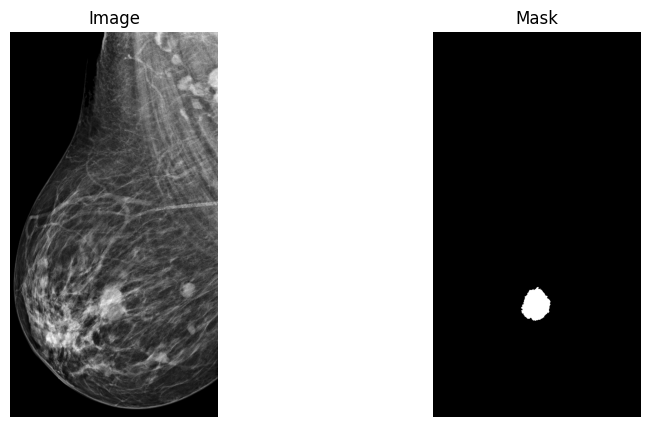

Unique values in the mask: [0 1]


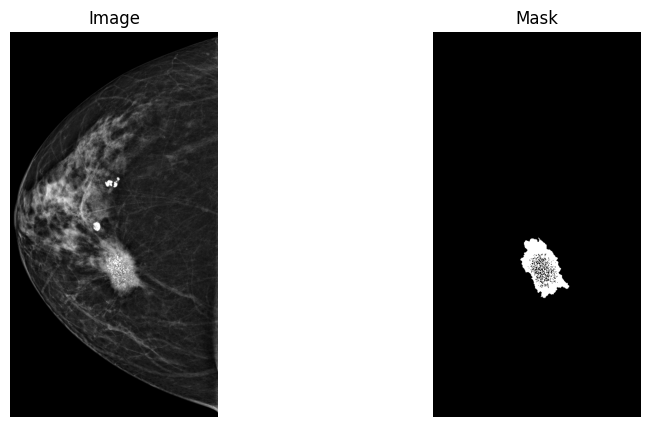

Unique values in the mask: [0 1]


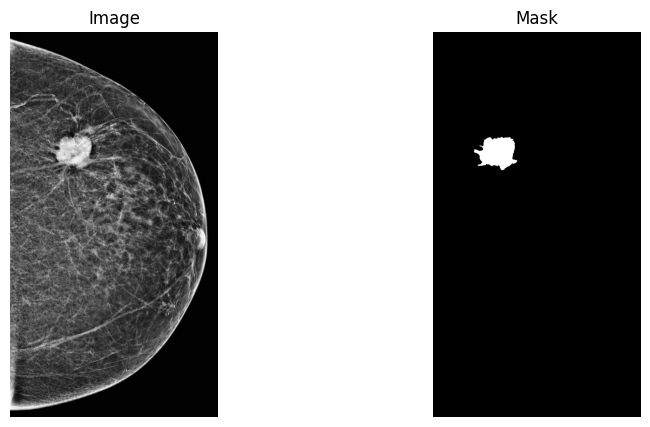

Unique values in the mask: [0 1]


In [23]:
show_img_mask(dataset=train_dataset, batch=3, image_number=2)

**Loading Class Weights (To treat class imbalance)**

Iterate through the train_dataset to count class frequencies:

- Given that the masks are one-hot encoded; sum the one-hot vectors to get the total count for each class.

Calculate class weights: The idea is to inversely weight the frequency of each class. A common approach to ensure that less frequent classes get a higher weight is;

- formula weight = 1 / (class_frequency / total_samples)

In [ ]:
def calculate_class_weights(dataset, n_classes):
    """
    Calculate class weights based on the frequency of each class in the dataset, processing batchwise.
    
    Args:
    - dataset: A tf.data.Dataset object containing (image, mask) pairs.
    - n_classes: Total number of classes, including the background.
    
    Returns:
    - A dictionary mapping class indices to their respective weights.
    """
    class_counts = np.zeros(n_classes)
    
    for _, masks in dataset:
        batch_counts = np.sum(masks, axis=(0, 1, 2))
        class_counts += batch_counts
        
        del masks, batch_counts
        gc.collect()
        
    # Calculate class weights
    total_samples = np.sum(class_counts)
    class_weights = total_samples / (n_classes * class_counts)
    
    # Convert to dictionary
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    return class_weight_dict

In [ ]:
# class_weight_dict = calculate_class_weights(train_dataset, n_classes)

# print("Class Weights:", class_weight_dict)

In [ ]:
# if not cropped

# class_weight_dict = {0: 0.20107391312794007, 1: 47.00139842603931, 2: 211.90172282762302, 3: 2332.7870561797754, 4: 3563.364258555133}

In [ ]:
# if cropped

class_weight_dict = {0: 0.2022681349167933, 1: 22.695173770744628, 2: 95.19659509349147, 3: 1111.0262316708104, 4: 1664.8583550020528}

### **Define the Unet Model**

VGG Shaped Unet model Architecture for multiclass segmentation

In [24]:
from vgg_unet_model import TL_unet_model

In [ ]:
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
model = TL_unet_model(input_shape, num_classes=n_classes)

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
unet_model_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])
display(unet_model_df)

**Compile Model**

test with 
* different optimizers - adam, rmsprop, sgd
* loss functions - categorical_crossentropy (one hot encoding needed), focal loss, sparse_categorical_crossentropy, iou/jaccard
* metrics - iou, dice coefficient, Fscore

In [26]:
from loss_and_metrics import jaccard_coef_multiclass, dice_coef_multiclass, combined_jaccard_dice_loss_multiclass, f1score_multiclass, specificity_multiclass, jaccard_loss_multiclass, dice_loss_multiclass, focal_loss_multiclass

with strategy.scope():
    model = model
    
    metrics = [
        f1score_multiclass,
        specificity_multiclass,
        jaccard_coef_multiclass,
        dice_coef_multiclass,
        'categorical_accuracy'
    ]
    
    loss_function = combined_jaccard_dice_loss_multiclass(alpha=0.5)
    # 'categorical_crossentropy'
    # jacard_loss_multiclass
    # dice_loss_multiclass
    # focal_loss_multiclass(alpha=0.5, gamma=2.0)
    
    loss_name = 'combined_jaccard_dice_loss' # to be used to create directories
    #  other options include 'jaccard_loss', 'dice_loss', 'focal_loss', 'categorical', 'combined_jaccard_dice_loss'

    model.compile(optimizer=Adam(lr=1e-5),
                  loss=loss_function,
                  metrics=metrics)

    model.summary()


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

**Train the model**

In [ ]:
model_name = 'vgg_unet'    
    
logs_directory = '../../logs/all_classes/' + model_name + '/' + loss_name + '/'
results_dir = '../../results/all_classes/' + model_name + '/' + loss_name + '/'

if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(logs_directory):
    os.makedirs(logs_directory)

In [27]:
checkpoint_path = logs_directory + 'vgg_unet_model_best_weights.hdf5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True, 
                                   save_weights_only=False, 
                                   mode='min')

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               verbose=1, 
                               mode='min')

In [28]:
# If starting with pre-trained weights. 
# model.load_weights('???.hdf5')

epochs = 5

history = model.fit(train_dataset, 
                    epochs=epochs, 
                    validation_data=test_dataset,
                    class_weight=class_weight_dict,  
                    verbose=1, 
                    shuffle=False,
                    callbacks=[model_checkpoint, early_stopping]
                   )


model.save(logs_directory + 'vgg_unet_model_final_weights_epoch_{}.hdf5'.format(epochs))

Epoch 1/5
36/36 [==============================] - 143s 4s/step - loss: 0.9595 - f1score: 0.0534 - specificity: 0.4383 - jaccard_coef: 0.0276 - dice_coef: 0.0534 - val_loss: 0.9698 - val_f1score: 0.0400 - val_specificity: 0.0516 - val_jaccard_coef: 0.0205 - val_dice_coef: 0.0400

Epoch 00001: val_loss improved from inf to 0.96977, saving model to ../../logs/annotation_overlap_black_pixels/malignant_mass\simple_unet_model_best_weights.hdf5
Epoch 2/5
36/36 [==============================] - 11s 315ms/step - loss: 0.9481 - f1score: 0.0683 - specificity: 0.5476 - jaccard_coef: 0.0355 - dice_coef: 0.0683 - val_loss: 0.9595 - val_f1score: 0.0534 - val_specificity: 0.6401 - val_jaccard_coef: 0.0275 - val_dice_coef: 0.0534

Epoch 00002: val_loss improved from 0.96977 to 0.95954, saving model to ../../logs/annotation_overlap_black_pixels/malignant_mass\simple_unet_model_best_weights.hdf5
Epoch 3/5
36/36 [==============================] - 29s 814ms/step - loss: 0.9440 - f1score: 0.0736 - specifi

### **Evaluations**

**Accuracy and Loss**

In [42]:
loss, f1score, specificity, iou, dice, accuracy = model.evaluate(test_dataset)

content = f"""
Loss: {loss}
F1-Score: {f1score}
Specificity: {specificity}
IoU / Jaccard Coeff: {iou}
Dice Coeff: {dice}
Categirical Accuracy: {accuracy}
"""

print(content)

filename = os.path.join(results_dir, 'model_evaluation_results.txt')

with open(filename, 'w') as file:
    file.write(content)

print("The evaluation metrics have been saved to:", filename)


9/9 [==============================] - 1s 77ms/step - loss: 0.9256 - f1score: 0.0974 - specificity: 0.7134 - jaccard_coef: 0.0514 - dice_coef: 0.0974

Loss: 0.9255882501602173
F1-Score: 0.0973924994468689
Specificity: 0.7133811116218567
IoU / Jaccard Coeff: 0.05143098160624504
Dice Coeff: 0.0973925068974495

The evaluation metrics have been saved to: ../../results/annotation_overlap_black_pixels/malignant_mass/model_evaluation_results.txt


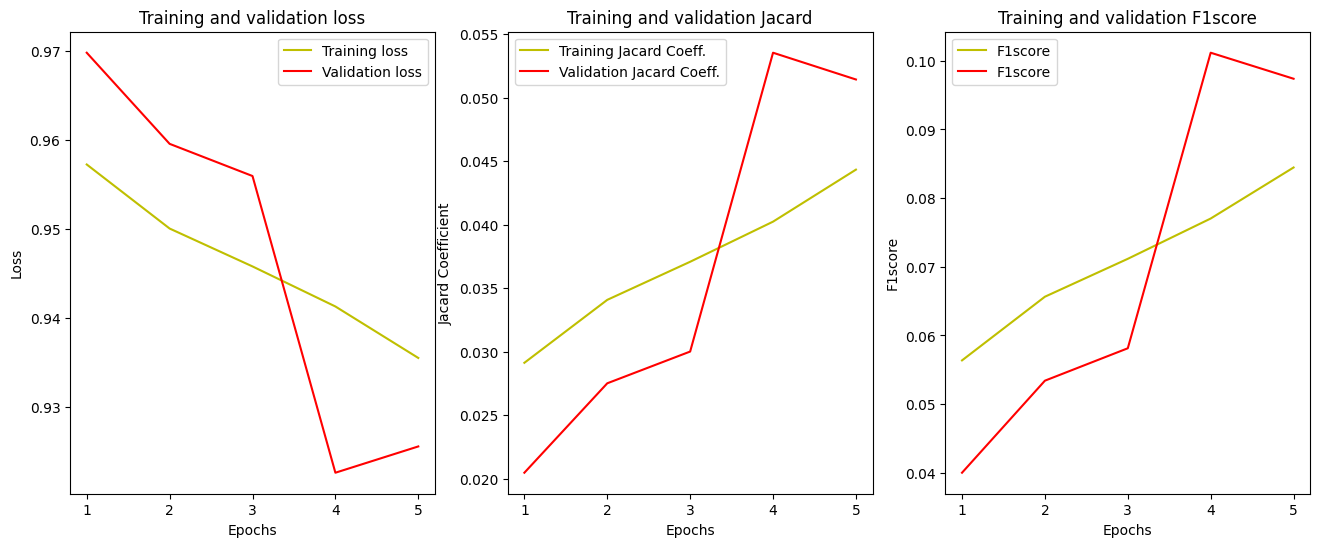

In [30]:
#plot the training and validation accuracy and loss at each epoch

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Plot the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].plot(epochs, loss, 'y', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and validation Jaccard Coef
jc = history.history['jaccard_coef_multiclass']
val_jc = history.history['val_jaccard_coef_multiclass']
axs[1].plot(epochs, jc, 'y', label='Training Jacard Coeff.')
axs[1].plot(epochs, val_jc, 'r', label='Validation Jacard Coeff.')
axs[1].set_title('Training and validation Jacard')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Jacard Coefficient')
axs[1].legend()

fs = history.history['f1score_multiclass']
val_fs = history.history['val_f1score_multiclass']
axs[2].plot(epochs, fs, 'y', label='F1score')
axs[2].plot(epochs, val_fs, 'r', label='F1score')
axs[2].set_title('Training and validation F1score')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('F1score')
axs[2].legend()

plt.show()

fig.savefig(os.path.join(results_dir, 'training_validation_metrics.png'))

In [31]:
# from tensorflow.keras.models import load_model

# model_path = '/kaggle/working/logs/model_epoch_59.hdf5'

# loaded_model = load_model(model_path, compile=False)  

**Average IoU Score**

In [32]:
def calculate_batch_iou(y_true, y_pred, num_classes):
    """Calculate batch IoU for each class."""
    ious = []
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(y_pred, depth=num_classes)

    for class_id in range(num_classes):
        y_true_c = y_true[..., class_id]
        y_pred_c = y_pred[..., class_id]

        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - intersection
        iou = intersection / (union + tf.keras.backend.epsilon())
        ious.append(iou)

    return tf.stack(ious)  # Stack to create a single tensor for the batch

In [43]:
total_iou = tf.zeros([n_classes])
total_batches = 0

for images, masks in test_dataset:
    preds = model.predict(images)
    batch_iou = calculate_batch_iou(masks, preds, num_classes=n_classes)
    total_iou += batch_iou
    total_batches += 1

mean_iou = total_iou / total_batches
    
mean_iou_content = "\nClass-wise Mean IoU:\n"
for i, iou in enumerate(mean_iou):
    mean_iou_content += f"Class {i}: Mean IoU = {iou.numpy()}\n"    

print(mean_iou_content)

with open(filename, 'a') as file:
    file.write('\n' + mean_iou_content)

print("Mean IoU has been added to:", filename)

Mean IoU = [0.2236921]
Mean IoU has been added to: ../../results/annotation_overlap_black_pixels/malignant_mass/model_evaluation_results.txt


**Confusion Matrix**

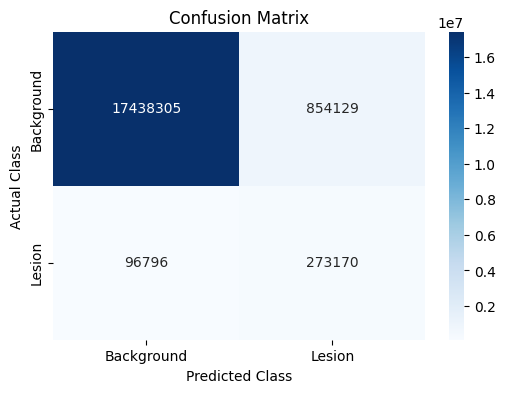

<Figure size 640x480 with 0 Axes>

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_true_labels = []
all_predicted_labels = []

for images, masks in test_dataset:
    predictions = model.predict(images)
    
    predicted_labels = np.argmax(predictions, axis=-1)
    true_labels = np.argmax(masks, axis=-1)
    
    all_predicted_labels.extend(predicted_labels.flatten())
    all_true_labels.extend(true_labels.flatten())
    
    del predicted_labels, true_labels
    gc.collect()


cm = confusion_matrix(all_true_labels, all_predicted_labels)

plt.figure(figsize=(10, 8))

class_names = ['background', 'malignant mass', 'benign mass', 'macrocalcification', 'microcalcification']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

plt.savefig(os.path.join(results_dir, 'confusion_matrix.png'))
plt.show()
plt.clf()

## **Predictions**

**Predict on Test Image**

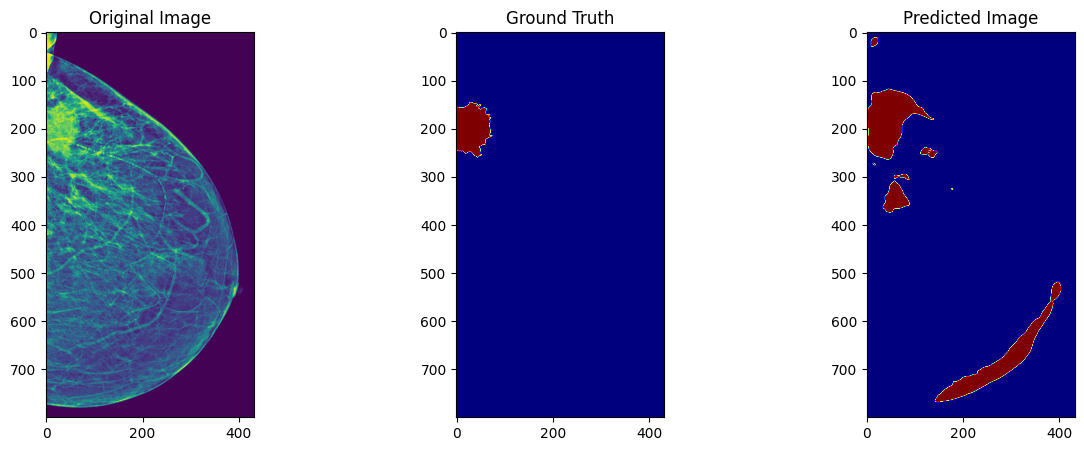

<Figure size 640x480 with 0 Axes>

In [49]:
def check_predictions(dataset, batch, img):
    for images, masks in dataset.take(batch):

        predicted_masks = model.predict(images)

        predicted_masks = tf.argmax(predicted_masks, axis=-1)

        masks = tf.argmax(masks, axis=-1)

        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(images[img])
        plt.title("Original Image")

        plt.subplot(132)
        plt.imshow(masks[img], cmap='jet')
        plt.title("Ground Truth")

        plt.subplot(133)
        plt.imshow(predicted_masks[img], cmap='jet')
        plt.title("Predicted Image")

        plt.savefig(os.path.join(results_dir, 'predictions_on_test_image.png'))
        plt.show()
        plt.clf()
        
check_predictions(dataset=test_dataset, batch=1, img=4)

**Predict on Unseen Data**

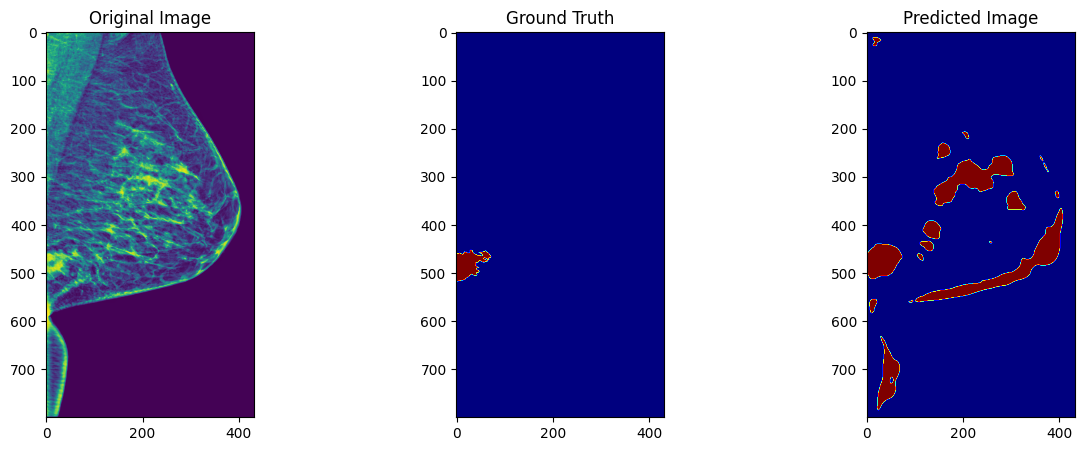

<Figure size 640x480 with 0 Axes>

In [50]:
def predict_single_image_mask(model, image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)
    image, new_height, new_width = crop_test_image(image.numpy().squeeze())
    image = image.reshape(new_height, new_width, 1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = image / 255
    image = tf.image.resize(image, image_size)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.math.round(mask / 64)
    mask = tf.image.resize(mask, image_size, method='nearest')
    
    image = tf.expand_dims(image, axis=0)
    mask = tf.expand_dims(mask, axis=0)
    
    predicted_mask = model.predict(image)
    
    predicted_mask = tf.argmax(predicted_mask, axis=-1)

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(image[0])
    plt.title("Original Image")

    plt.subplot(132)
    plt.imshow(mask[0], cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(133)
    plt.imshow(predicted_mask[0], cmap='jet')
    plt.title("Predicted Image")

    plt.savefig(os.path.join(results_dir, 'predictions_on_unseen_image.png'))
    plt.show()
    plt.clf()
    
predict_single_image_mask(model, image_files_unseen[0], mask_files_unseen[0])

In [52]:
def predict_single_image(model, image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)
    image, _ = wrap_preprocessing(image, np.zeros(image.shape))
    image = tf.image.resize(image, image_size)
    image = image / 255
    
    image = tf.expand_dims(image, axis=0)
    
    predicted_mask = model.predict(image)
    
    predicted_mask = tf.math.round(predicted_mask)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(image[0])
    plt.title("Original Image")
    
    plt.subplot(122)
    plt.imshow(predicted_mask[0], cmap='jet')
    plt.title("Predicted Image")
    
    plt.show()

# image_path = '/kaggle/input/unseen/0248-LCC.png'
# predict_single_image(model, image_path)